In [1]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = ""
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_directory_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": "DL3",
}
load_EventDisplay = True
EventDisplay_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203"
input_simtel_file = "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
input_filenames = {
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/MODELS"


In [2]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Model tuning

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains benchmarks which are aimed at evaluating the performance of the models
_before_ committing to them.

As such, this notebook actually trains, tests and validates _more than one_ instance of the model of choice (defined by its configuration file in the current analysis directory).
This is the main reason why the notebook has been separated from the main ones, which should validate only the final realization of the models (i.e. the one that will be actually used to apply the estimates in the subsequent steps of the analysis).

**Data level:** DL1b (telescope-wise image parameters) + DL2a (only shower geometry for energy estimation, with estimated energy for particle classification)

**Requirements and steps to reproduce:**

To run this notebook you will need a TRAINING file generated using _protopipe-TRAINING_ .

The data format required to run the notebook is the current one used by _protopipe_.

To get a filled notebook and reproduce these results,

- get the necessary input files using ``protopipe-TRAINING`` (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n MODELS/benchmarks_MODELS_tuning``

To obtain the list of all available parameters add ``--help-notebook``.

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents

* [Validation curves](#Validation-curves)
* [Learning curves](#Learning-curves)

## Imports
[back to top](#Table-of-contents)

In [3]:
import glob
import gzip
import importlib
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from protopipe.pipeline.utils import load_config
from protopipe.mva import TrainModel
from protopipe.mva.utils import make_cut_list, prepare_data

## Model generation
[back to top](#Table-of-contents)

In [4]:
analyses_directory = ""
analysis_name = ""
camera = "LSTCam" # Camera model to validate
estimated_quantity = "energy" # energy or classification
model_configuration_filename = "RandomForestRegressor.yaml" # RandomForestRegressor.yaml, AdaBoostRegressor.yaml or RandomForestClassifier.yaml
output_directory = Path.cwd() # default output directory for plots
max_events = 10000 # Integer number of maximum events to consider from input data (None == max, default: 10000)
param_name = "max_depth" # Name of the parameter against which evaluate the model
scoring = "explained_variance" # e.g. "explained_variance", "roc_auc", ... (see https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
cv = 2 # Cross-Validation (CV)method: int for int, list [n_splits, train_size] for ShuffleSplit (default: 2-fold cross validation)

In [5]:
# Set CV
if ((type(cv) is int) or (cv is None)) and (estimated_quantity=="classification"):
    if cv is None:
        cv = 5
    print(f"Selected CV method = {cv}-StratifiedKFold cross validation")
    cv_to_use = cv
elif ((type(cv) is int) or (cv is None)) and (estimated_quantity!="classification"):
    if cv is None:
        cv = 5
    print(f"Selected CV method = {cv}-KFold cross validation")
    cv_to_use = cv
elif type(cv) is list:
    print(f"Selected CV method = ShuffleSplit with {cv[0]} splits and a train size of {cv[1]}")
    cv_to_use = ShuffleSplit(n_splits=cv[0], train_size=cv[1], random_state=0)

Selected CV method = 2-KFold cross validation


In [6]:
model_configuration_path = Path(analyses_directory) / analysis_name / "configs" / model_configuration_filename

In [7]:
# Load configuration files
cfg = load_config(model_configuration_path)

# Get info from configs
# Map model types to the models supported by the script
model_types = {"regressor": ["RandomForestRegressor.yaml",
                                 "AdaBoostRegressor.yaml"],
                "classifier": ["RandomForestClassifier.yaml"]}

def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val in value:
             return key

model_type = get_key(model_types, model_configuration_filename)
method_name = cfg["Method"]["name"].split(".")[-1]

In [8]:
target_name = cfg["Method"]["target_name"]

if model_type == "regressor":
    try:
        log_10_target = cfg["Method"]["log_10_target"]
    except KeyError:
        log_10_target = True

    if log_10_target:
        target_name = f"log10_{target_name}"

In [9]:
features_basic = cfg["FeatureList"]["Basic"]
features_derived = cfg["FeatureList"]["Derived"]
features = features_basic + list(features_derived)
features = sorted(features)
print(f"Model features = {features}")

Model features = ['concentration_pixel', 'h_max', 'hillas_length', 'hillas_width', 'impact_dist', 'leakage_intensity_width_1', 'log10_WLS', 'log10_intensity', 'phi_origin', 'r_origin']


In [10]:
# There is always at least one (main) model to initialize
model_to_use = cfg['Method']['name']
module_name = '.'.join(model_to_use.split('.', 2)[:-1])
class_name = model_to_use.split('.')[-1]
module = importlib.import_module(module_name)  # sklearn.XXX
model = getattr(module, class_name)
print(f"Going to use {module_name}.{class_name}...")

# Check for any base estimator if main model is a meta-estimator
if "base_estimator" in cfg['Method']:
    base_estimator_cfg = cfg['Method']['base_estimator']
    base_estimator_name = base_estimator_cfg['name']
    base_estimator_pars = base_estimator_cfg['parameters']
    base_estimator_module_name = '.'.join(base_estimator_name.split('.', 2)[:-1])
    base_estimator_class_name = base_estimator_name.split('.')[-1]
    base_estimator_module = importlib.import_module(base_estimator_module_name)  # sklearn.XXX
    base_estimator_model = getattr(base_estimator_module, base_estimator_class_name)
    initialized_base_estimator = base_estimator_model(**base_estimator_pars)
    print(f"...based on {base_estimator_module_name}.{base_estimator_class_name}")
    initialized_model = model(base_estimator=initialized_base_estimator,
                              **cfg['Method']['tuned_parameters'])
else:
    initialized_model = model(**cfg['Method']['tuned_parameters'])

Going to use sklearn.ensemble.RandomForestRegressor...


In [11]:
# Pinpoint the data
input_data_path = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation")
signal_input_file = "TRAINING_energy_tail_gamma_merged.h5"
# Get the selection cuts for signal
sig_cuts = make_cut_list(cfg["SigFiducialCuts"])

signal_before_cuts = pd.read_hdf(input_data_path / signal_input_file, camera, mode="r")
print(f"Number of signal images available before cuts: {len(signal_before_cuts)}")

data_sig = prepare_data(ds=signal_before_cuts,
                        derived_features=features_derived,
                        select_data=True,
                        cuts=sig_cuts)
    
# Select data and add derived features
if estimated_quantity == "classification":
    
    input_data_path = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_particle_classification")
    background_input_file = "TRAINING_classification_tail_proton_merged.h5" 
    
    background_before_cuts = pd.read_hdf(input_data_path / background_input_file, camera, mode="r")
    print(f"Number of background images available before cuts: {len(background_before_cuts)}")
    
    # Get the selection cuts for background
    bkg_cuts = make_cut_list(cfg["BkgFiducialCuts"])
    data_bkg = prepare_data(ds=background_before_cuts,
                            label=0,
                            derived_features=features_derived,
                            select_data=True,
                            cuts=bkg_cuts)
    
if max_events:
    data_sig = data_sig[0:max_events]
    if estimated_quantity == "classification":
        data_bkg = data_bkg[0:max_events]

print(f"Number of signal images available after cuts: {len(data_sig)} ({len(data_sig)/len(signal_before_cuts)*100:.2f}%)")
if estimated_quantity == "classification":
    print(f"Number of background images available after cuts: {len(data_bkg)} ({len(data_bkg)/len(background_before_cuts)*100:.2f}%)")

Number of signal images available before cuts: 2158224


Number of signal images available after cuts: 10000 (0.46%)


In [12]:
# Get the training features values
# Get the target values
if model_type == "classifier":
    X = pd.concat([data_sig[features], data_bkg[features]])
    y = pd.concat([data_sig[target_name], data_bkg[target_name]])
else:
    X = data_sig[features]
    y = data_sig[target_name]

## Validation curves
[back to top](#Table-of-contents)

In [13]:
param_range = [10, 20, 30, 40, 50]
print(f"Parameter range = {param_range}")

if param_name is None:
    raise ValueError("param_name option undefined")

Parameter range = [10, 20, 30, 40, 50]


In [14]:
train_scores, test_scores = validation_curve(initialized_model,
                                             X,
                                             y,
                                             param_name=param_name,
                                             param_range=param_range,
                                             cv=cv,
                                             scoring=scoring, 
                                             n_jobs=-1
                                            )

In [15]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

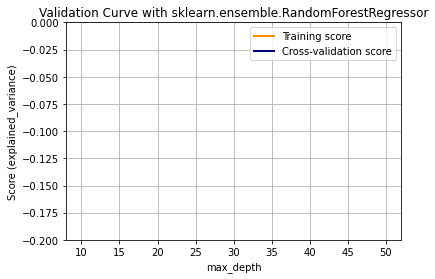

In [16]:
plt.title(f"Validation Curve with {module_name}.{class_name}")
plt.xlabel(f"{param_name}")
plt.ylabel(f"Score ({scoring})")
lw = 2
plt.ylim(-0.2, 0)
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.savefig(f"protopipe_test_model_validation_curve_{estimated_quantity}_{param_name}_{model_configuration_filename.split('.')[0]}.png")
plt.show()

## Learning curves
[back to top](#Table-of-contents)

In [17]:
def compute_learning_curve(estimator, X, y, cv=None,
                        scoring = None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Compute mean and standard deviation of train scores, test scores and fit times,

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring = scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    return (train_sizes,
            train_scores_mean, train_scores_std,
            test_scores_mean, test_scores_std,
            fit_times_mean, fit_times_std)

def plot_learning_curve(train_sizes, train_scores_mean, train_scores_std,
                        test_scores_mean, test_scores_std,
                        fit_times_mean, fit_times_std,
                        scoring, title=None, axes=None, ylim=None
                        ):
    """Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    
    Parameters
    ----------
    scoring: str or callable
        Scoring function
    title : str, default: None
        Title for the chart.
    axes : array-like of shape (3,), default: None
        Axes to use for plotting the curves.
    ylim : tuple of shape (2,), default: None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).
    train_scores_mean: np.array
        Mean of the train scores
    train_scores_std: np.array
        Standard deviation of the train scores
    test_scores_mean: np.array
        Mean of the test scores
    test_scores_std: np.array
        Standard deviation of the test scores
    fit_times_mean: np.array
        Mean of the times spent for fitting in seconds
    fit_times_std: np.array
        Standard deviation of the times spent for fitting in seconds
    """
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(f"Score ({scoring})")
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Times spent for fitting (seconds)")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Times spent for fitting (seconds)")
    axes[2].set_ylabel(f"Score ({scoring})")
    axes[2].set_title("Performance of the model")
    #if ylim is not None:
    #    axes[2].set_ylim(*ylim)
    
    return plt

In [18]:
(train_sizes,
 train_scores_mean,
 train_scores_std,
 test_scores_mean,
 test_scores_std,
 fit_times_mean,
 fit_times_std) = compute_learning_curve(model(**cfg['Method']['tuned_parameters']), X, y, cv=cv, scoring=scoring, n_jobs=-1)

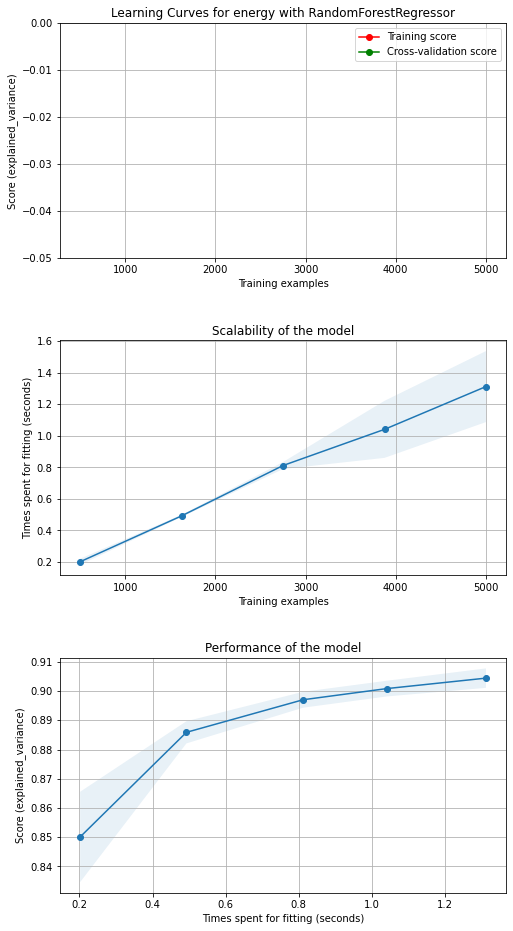

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))
plt.subplots_adjust(hspace=0.35)

title = f"Learning Curves for {estimated_quantity} with {model_configuration_filename.split('.')[0]}"

plot_learning_curve(train_sizes,
                    train_scores_mean, train_scores_std,
                    test_scores_mean, test_scores_std,
                    fit_times_mean, fit_times_std,
                    scoring,
                    title,
                    axes,
                    ylim=(-0.05,0)
                    )

plt.show()